In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
import numpy as np
import torch
from transformers import CLIPProcessor, CLIPModel
import cv2
import os

In [20]:
def objectDetection(img_path:str, model) -> list:
    image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    image_name = os.path.basename(img_path)
    image_name = image_name.split('.')[0]

    result = model(image)
    result.crop(save_dir=os.path.join("YOLO", image_name))
    detectedObjects = result.render()[0]
    path = os.path.join("YOLO", image_name, 'crops', '**', '*.jpg')

    listOfObjects = []
    for filename in glob(path):
        obj = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
        listOfObjects.append(obj)     

    return listOfObjects, detectedObjects

In [21]:
def similarity_top(similarity_list:list, similarity_list2: list, listOfObjects:list, N) -> tuple():
    results = zip(range(len(similarity_list)), similarity_list, similarity_list2)
    results = sorted(results, key=lambda x: x[1], reverse=True)
    images = []
    scores=[]
    scores2=[]
    for index, score, score2 in results[:N]:
        scores.append(score)
        scores2.append(score2)
        images.append(listOfObjects[index])

    return scores, scores2, images


def findObjects(listOfObjects:list, query:list, model, preprocess, device:str, N) -> tuple():
    # objects = torch.stack([preprocess(Image.fromarray(im)) for im in listOfObjects]).to(device)

    # with torch.no_grad():
    #     image_features = model.encode_image(objects)
    #     image_features /= image_features.norm(dim=-1, keepdim=True)

    #     text_features = model.encode_text(clip.tokenize(query).to(device))
    #     text_features /= text_features.norm(dim=-1, keepdim=True)

    # similarity = (text_features.cpu().numpy() @ image_features.cpu().numpy().T) * 100
    # similarity = similarity[0]
    # scores, images = similarity_top(similarity, listOfObjects, N=N)     

    # return scores, images

    similarity1=[]
    similarity2=[]

    for i in listOfObjects:
        objects = preprocess(text=query, images=Image.fromarray(i), return_tensors="pt", padding=True)

        outputs = model(**objects)
        logits_per_image = outputs.logits_per_image
        # logits_per_image = logits_per_image.softmax(dim=1)
        similarity1.append(logits_per_image[0][0].item())
        similarity2.append(logits_per_image[0][1].item())

    scores, scores2, images = similarity_top(similarity1, similarity2, listOfObjects, N=N)

    for i in range(5):
        print(str(scores[i]) + "      " + str(scores2[i]))
        print(scores[i]-scores2[i])
        scores[i]=scores[i]-scores2[i]

    return scores, images

In [22]:
def plotResults(scores:list, images:list, n):
    plt.figure(figsize=(20,5))
    for index, img in enumerate(images):
        plt.subplot(1,n, index+1)
        plt.imshow(img)
        plt.title(scores[index])
        plt.axis('off')
    plt.show()

In [23]:
OBJDETECTIONMODEL = 'yolov5x6'
OBJDETECTIONREPO = 'ultralytics/yolov5'
DEVICE = 'cpu'
N = 5

In [24]:
objectDetectorModel = torch.hub.load(OBJDETECTIONREPO, OBJDETECTIONMODEL)
objectFinderModel = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
preProcess = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

Using cache found in C:\Users\prath/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-2-8 Python-3.9.18 torch-2.1.2+cpu CPU

Fusing layers... 
YOLOv5x6 summary: 574 layers, 140730220 parameters, 0 gradients, 209.6 GFLOPs
Adding AutoShape... 


In [25]:
def pipeline(image, query):
    listOfObjects, detectedObjects = objectDetection(image, objectDetectorModel)
    scores, images = findObjects(listOfObjects, query, objectFinderModel, preProcess, DEVICE, N)
    plt.figure(figsize=(20,5))
    plt.axis('off')
    plt.imshow(detectedObjects)
    plotResults(scores, images, N)

Saved 1 image to YOLO\hello12
Saved results to YOLO\hello12



27.582773208618164      23.707672119140625
3.875101089477539
25.492107391357422      24.07194709777832
1.4201602935791016
25.396602630615234      24.827342987060547
0.5692596435546875
25.307600021362305      24.462900161743164
0.8446998596191406
24.43092918395996      24.137914657592773
0.2930145263671875


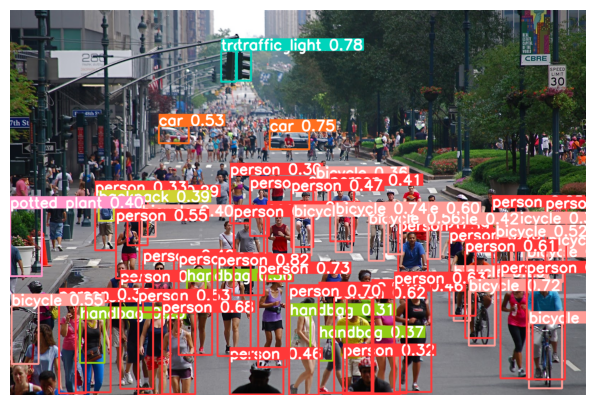

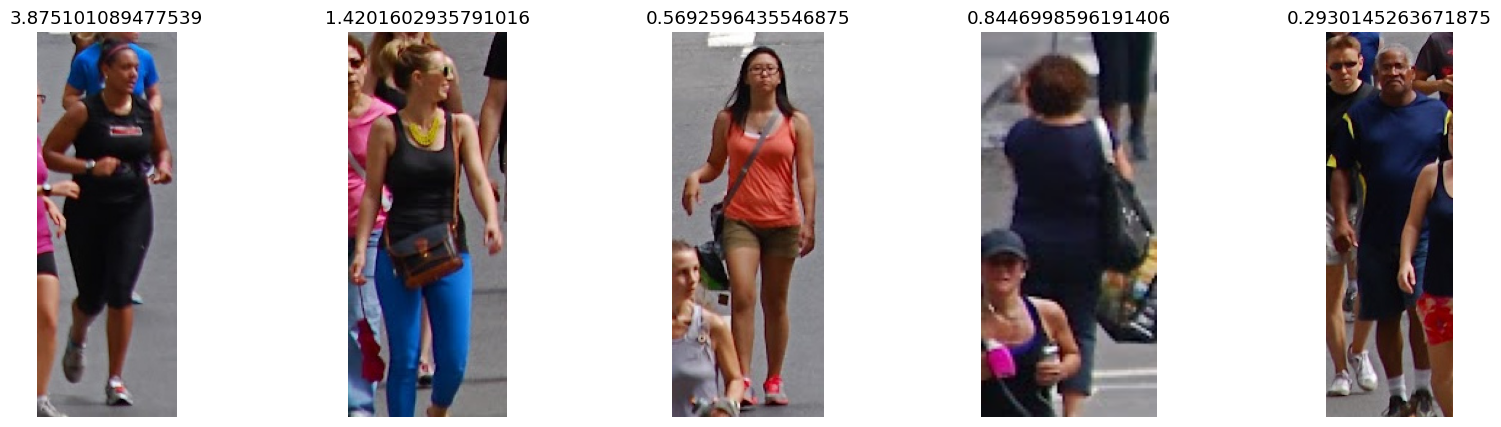

In [29]:
pipeline("hello.jpg", ['woman with black clothes','person'])

Saved 1 image to YOLO\hello13
Saved results to YOLO\hello13



29.974090576171875      24.07194709777832
5.902143478393555
27.825082778930664      26.134326934814453
1.690755844116211
27.811561584472656      25.60747528076172
2.2040863037109375
27.51642608642578      24.827342987060547
2.6890830993652344
26.804141998291016      23.32740592956543
3.476736068725586


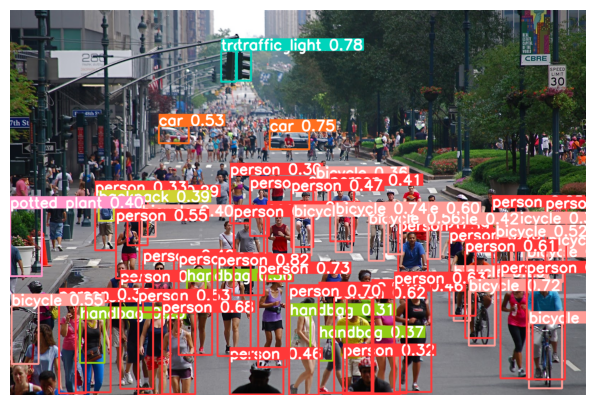

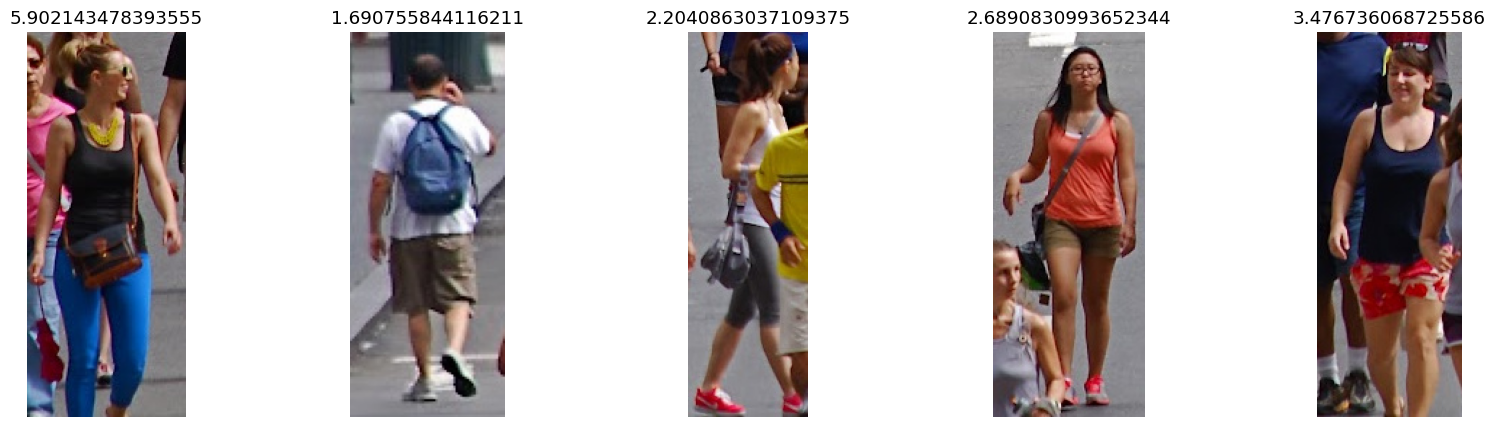

In [30]:
pipeline("hello.jpg", ['woman with blue pants','person'])

Saved 1 image to YOLO\hello14
Saved results to YOLO\hello14



34.16472625732422      26.134326934814453
8.030399322509766
32.11817932128906      25.484241485595703
6.633937835693359
27.827667236328125      25.60747528076172
2.2201919555664062
27.653844833374023      24.462900161743164
3.1909446716308594
27.637239456176758      24.43250846862793
3.204730987548828


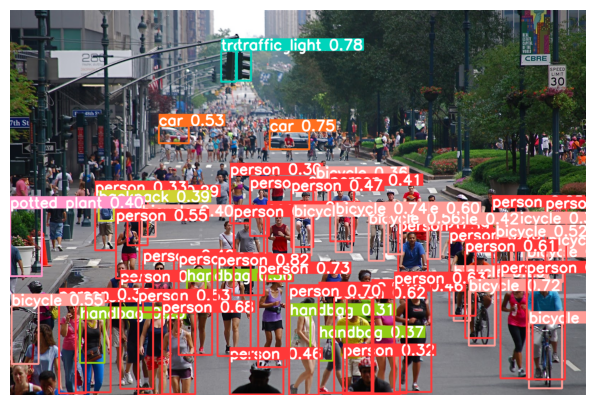

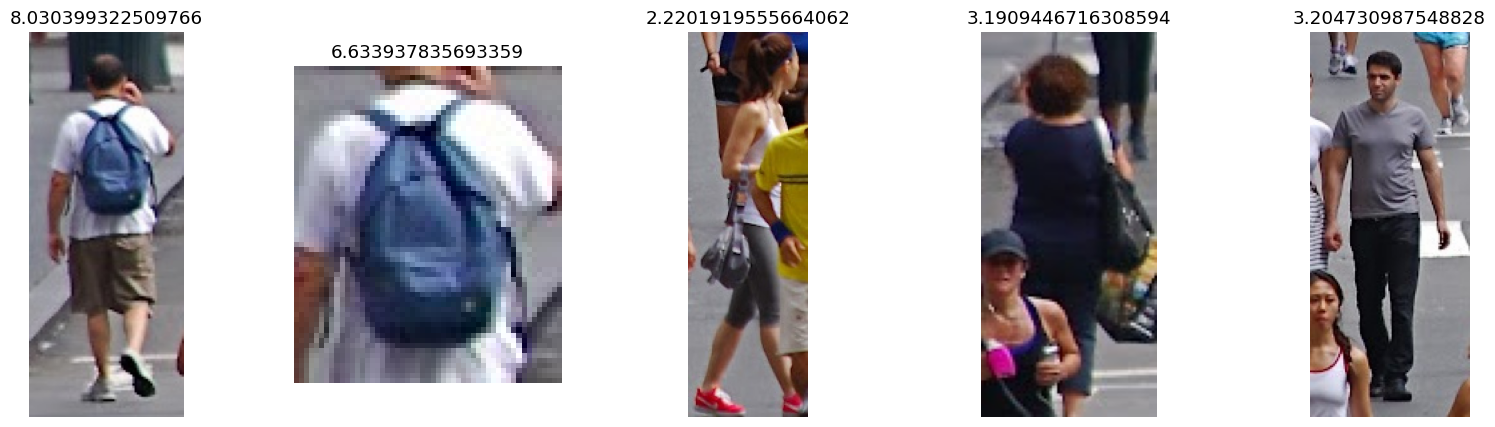

In [31]:
pipeline("hello.jpg", ['man with blue backpack','person'])